# 1.MORDM OPTIMIZATION

# 1.1 Generate random policies

In [1]:
import pandas as pd
import numpy as np

from ema_workbench import load_results
from ema_workbench import Scenario

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [18]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Re-evaluation

In [24]:
from ema_workbench import Policy

policies = []
for i, result in enumerate(results_deep):
    outcomes_of_interest = result.iloc[:, :-3]
    for j, row in outcomes_of_interest.iterrows():
        policy = Policy(f'scenario {i} policy {j}', **row.to_dict())
        policies.append(policy)

In [25]:
from problem_formulation import get_model_for_problem_formulation

# We use the original problem formulation to account for the RfR policies
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [26]:
ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(500, policies=policies)
    
# experiments_reev, outcomes_reev = reeevaluation_results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 42 policies * 1 model(s) = 21000 experiments
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 10500 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14700 cases completed
[MainProcess/INFO] 16800 cases completed
[MainProcess/INFO] 18900 cases completed
[MainProcess/INFO] 21000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [53]:
# from ema_workbench import save_results
# save_results((experiments_reev, outcomes_reev), f'../results/mordm_exp_2_1000.tar.gz')

experiments_reev, outcomes_reev = load_results('../results/mordm_exp_2_1000.tar.gz') 
outcomes_reev_df = pd.DataFrame.from_dict(outcomes_reev)

[MainProcess/INFO] results saved successfully to D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_exp_2_1000.tar.gz


Comparing both cells below we can see how we have 66 unique policies.

In [54]:
experiments_reev.iloc[:,19:-3].duplicated().value_counts()

True     20958
False       42
dtype: int64

In [55]:
experiments_reev['policy'].nunique()

42

We now only chose the policies that keep the number of deaths under the threshold in ALL scenarios

In [56]:
outcomes_reev_df.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,2.100000e+04,2.100000e+04,2.100000e+04,21000.000000,21000.000000
mean,9.174717e+07,9.998493e+07,1.751971e+09,3407.984925,0.009067
std,3.406452e+08,2.086492e+07,2.994190e+08,7980.440903,0.030620
min,0.000000e+00,6.087036e+07,9.759000e+08,0.000000,0.000000
25%,1.544874e+06,8.173593e+07,1.572700e+09,112.189787,0.000105
50%,1.299621e+07,1.017962e+08,1.828800e+09,831.723645,0.001412
75%,4.840653e+07,1.158001e+08,2.015900e+09,2762.519602,0.005346
max,3.043916e+09,1.380248e+08,2.131200e+09,117778.445391,0.464258


In [57]:
outcomes_reev_df['policy']= experiments_reev['policy']
policy_names = outcomes_reev_df.policy.unique()

policies_of_interest = []
for policy in policy_names:
    policy_df = outcomes_reev_df[outcomes_reev_df['policy'] == policy]
    policy_df_logical = policy_df['Expected Number of Deaths'] > (0.0001*3*5)
    type(policy_df_logical)
    if policy_df_logical.any():
        continue
    else:
        policies_of_interest.append(policy)

policies_of_interest

[]

We can see that there is no policy that obeys the threshold under all scenarios. We therefore calculate the robustness using the thresholds.......

In [58]:
outcomes_reev_df_death= outcomes_reev_df[outcomes_reev_df['Expected Number of Deaths']<=(0.0001*3*5)]
outcomes_reev_df_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
0,2.783543e+06,1.158001e+08,1.572700e+09,179.850459,0.000142,scenario 0 policy 0
1,0.000000e+00,1.158001e+08,1.572700e+09,0.000000,0.000000,scenario 0 policy 0
2,0.000000e+00,1.158001e+08,1.572700e+09,0.000000,0.000000,scenario 0 policy 0
3,9.324408e+04,1.158001e+08,1.572700e+09,6.036863,0.000006,scenario 0 policy 0
5,2.700068e+06,1.158001e+08,1.572700e+09,178.331037,0.000139,scenario 0 policy 0
...,...,...,...,...,...,...
20988,1.014472e+07,6.087036e+07,1.828800e+09,545.680922,0.001139,scenario 4 policy 7
20989,9.778430e+06,6.087036e+07,1.828800e+09,645.111252,0.000651,scenario 4 policy 7
20993,8.841605e+06,6.087036e+07,1.828800e+09,540.934409,0.001111,scenario 4 policy 7
20995,4.810262e+06,6.087036e+07,1.828800e+09,254.312887,0.000532,scenario 4 policy 7


In [59]:
#Por ahora probamos sin evacuation costs y damage, que no estan especificados

max_deaths = 0.0001
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

thresholds = {'Dike Investment Costs':max_dike_costs, 'RfR Investment Costs':max_rfr_costs, 'Expected Number of Deaths':max_deaths}

overall_scores = {}
for policy in experiments_reev.policy.unique():
    logical = experiments_reev.policy == policy
    scores = {}
    for k, v in outcomes_reev.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [60]:
#overall_scores_filtered = overall_scores[(overall_scores['Expected Number of Deaths'] >= 0.990) & (overall_scores['RfR Investment Costs'] == 0.0)]

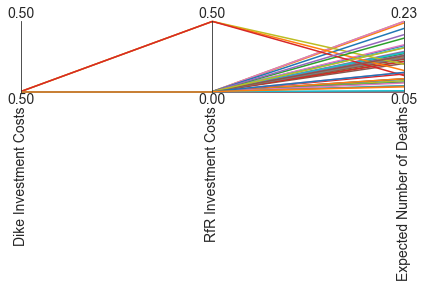

In [61]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

In [36]:
import functools

def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e3 # makes numbers nicer CAREFUL WITH UNITS
    
SMALLER = 'SMALLER'


max_deaths = 0.0001
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

Expected_Annual_Damage = costs
Dike_Investment_Costs = functools.partial(robustness, SMALLER, max_dike_costs)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, max_deaths)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, max_rfr_costs)
Evacuation_Costs = costs

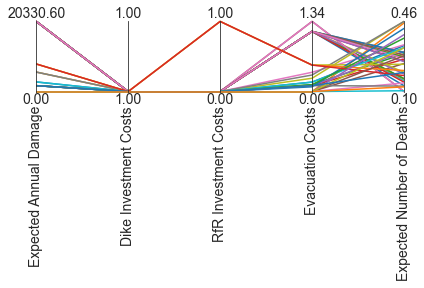

In [37]:
from ema_workbench.analysis import parcoords


funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths,
         'RfR Investment Costs':RfR_Investment_Costs,       
         'Evacuation Costs': Evacuation_Costs}

total_scores = {}
for policy in np.unique(experiments_reev['policy']):
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T#.reset_index(drop=True)
limits = parcoords.get_limits(data)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [38]:
data_death = data.sort_values(by=['Expected Number of Deaths']).tail(5)
data_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
scenario 4 policy 0,0.000000,1.0,0.0,0.000000,0.388
scenario 3 policy 2,1706.663501,1.0,0.0,0.090304,0.420
scenario 0 policy 1,0.000000,1.0,0.0,0.000000,0.448
scenario 2 policy 9,5642.665950,1.0,0.0,0.315184,0.456
scenario 2 policy 1,5642.665950,1.0,0.0,0.253699,0.456


In [39]:
outcomes_names = list(outcomes_reev.keys())
n_policies = experiments_reev['policy'].nunique()
n_experiments = len(experiments_reev)
n_exp_pol = n_experiments/n_policies

In [40]:
# To calculate the regret we find the maximum value for each outcome under each policy with the same values for the uncertainties
# Then, we calculate the regret and find the maximum regret to study which is the policy that has the lowest maximum regret
final_regret = {}
for outcome in outcomes_names:
    policy_dict = {}

    for i in range(1, n_policies+1):
        # We first find the maximum value for each outcome under all policies
        policy_row = outcomes_reev[outcome][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
        policy_dict['policy'+f"{i}"] = policy_row
    policy_df = pd.DataFrame.from_dict(policy_dict)
    maxValuesObj = policy_df.max(axis=1)
    regret_row = abs(policy_df.sub(maxValuesObj, axis='index'))
    final_regret[outcome] = regret_row.max()

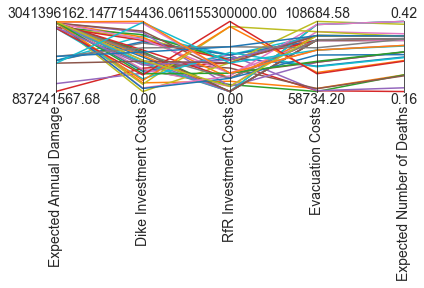

In [41]:
regret_df = pd.DataFrame.from_dict(final_regret)
limits = parcoords.get_limits(regret_df)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_df)
plt.show()

In [42]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments_reev['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes_reev[outcome.name], 
                         "policy":experiments_reev['policy'],
                         "scenario":experiments_reev['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\Willy\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


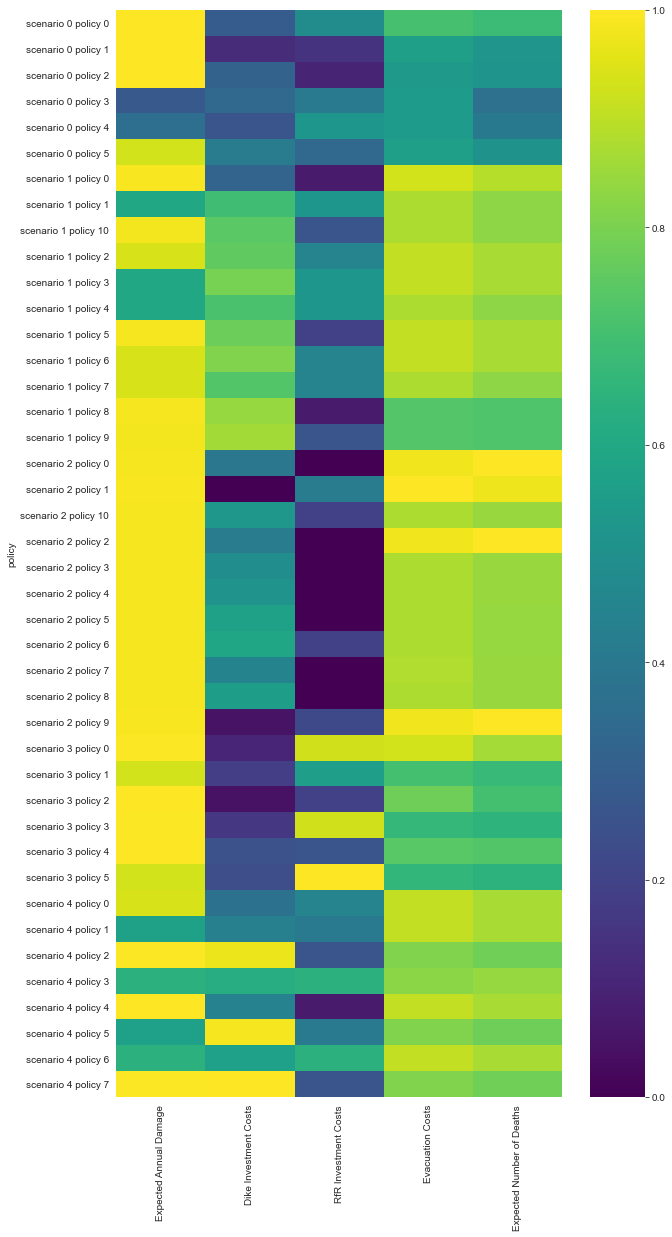

In [43]:
max_regret = pd.DataFrame(max_regret)

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=False, ax=ax)
plt.show()

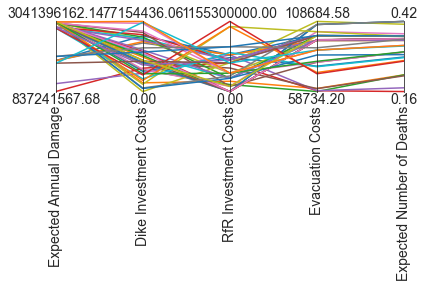

In [44]:
colors = sns.color_palette()

data = max_regret

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [45]:
max_regret_filtered = max_regret.sort_values(by=['Expected Number of Deaths']).head(5)
max_regret_filtered

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 0 policy 3,8.372416e+08,2.568929e+07,471600000.0,59312.374872,0.155753
scenario 0 policy 4,1.084577e+09,2.017342e+07,604800000.0,59312.374872,0.169940
scenario 0 policy 5,2.835476e+09,3.167961e+07,387000000.0,60809.460586,0.215320
scenario 0 policy 2,3.038494e+09,2.382076e+07,115300000.0,58734.198645,0.218888
scenario 0 policy 1,3.035366e+09,9.582432e+06,169200000.0,60924.990223,0.219046


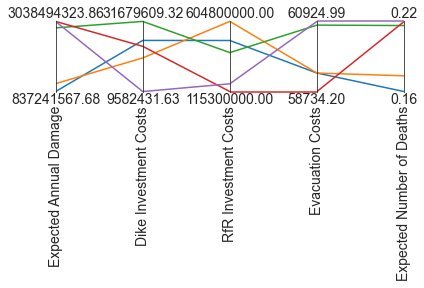

In [46]:
limits = parcoords.get_limits(max_regret_filtered)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_regret_filtered)
plt.show()

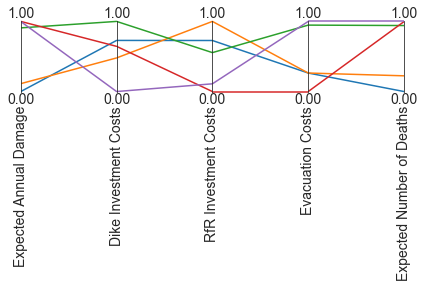

In [47]:
import pandas as pd
from sklearn import preprocessing

x = max_regret_filtered.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
max_regret_filtered_norm = pd.DataFrame(x_scaled, columns=max_regret_filtered.columns)


limits = parcoords.get_limits(max_regret_filtered_norm)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_regret_filtered_norm)
plt.show()

In [48]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

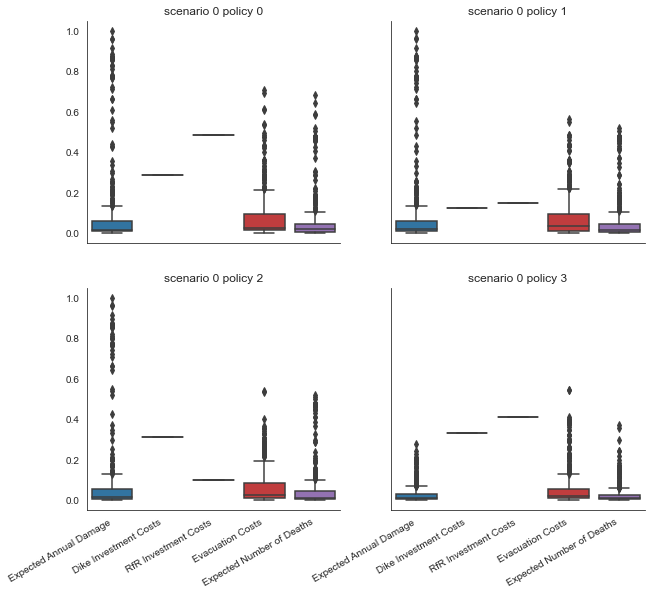

In [49]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],        
        axes[1,0],axes[1,1]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
fig.autofmt_xdate()
plt.show()

In [50]:
#esto sirve para filtrar de outcomes
outcomes_reev_logical = outcomes_reev['Expected Number of Deaths'] <= 0.0001
experiments_reev_of_interest = experiments_reev.loc[outcomes_reev_logical]
# outcomes_reev_of_interest_df = pd.DataFrame({k:v[outcomes_reev_logical] for k,v in outcomes_reev.items()})

In [51]:
max_rfr_costs = 1.1e9
max_dike_costs = 304e6
outcomes_reev_logical_2 = outcomes_reev_of_interest_df['RfR Investment Costs'] <= max_rfr_costs
outcomes_reev_of_interest_df = pd.DataFrame({k:v[outcomes_reev_logical_2] for k,v in outcomes_reev_of_interest_df.items()})

NameError: name 'outcomes_reev_of_interest_df' is not defined

In [ ]:
outcomes_reev_of_interest_df

In [ ]:
# plot results of domain criterion
limits = parcoords.get_limits(outcomes_reev_of_interest_df)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes_reev_of_interest_df)
plt.rcParams["figure.figsize"] = (10,15)
plt.show()

# End of document

# 1.3 Re-evaluate candidate solutions under uncertainty

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [ ]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation.tar.gz')

In [ ]:
policies.to_csv('moro polices.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

In [ ]:

data = overall_robustness.loc[:, 
                              ['Expected Number of Deaths', 'Expected Annual Damage', 'Total Investment Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()